# TMA4320 Introduction to Scientific Computation - spring 2022
Laget av Albert bayazidi, Abinida Jeyarajah, Synne Gilbu

### Project 2 - Industrial Mathematics

## Introduction

CryptoPunks is a collection of NFTs (Non-fungible token). Common to all of these CryptoPunks are that the figures are perfectly centered. In addition, they share a lot of the same features. This gives us the opportunity to use linear factorization techniques like non-negative matrix factorization (NMF).

This will be our main focus for this project. We will be investigating different properties from the NMF method, among other things. We will implement an algorithm for NMF, and we will look at how the norm will be affected when different values vary.

Further on, we want to have a closer look at the CryptoPunks. By splitting up the images into matrices we will be able to use the NMF on them. We will investigate the output of the NMF and how these vary for different values for $d$.

Lastly, we will add noise to our images. The NMF will in this case be quite helpful with denoising when we want to reconstruct the images. When we add noise, we will also observe the phenomena of underfitting and overfitting.

In [1]:
import numpy as np #numpylibrary
import numpy.linalg #calculate linear systems and norms
import matplotlib.pyplot as plt #import matplot 
import cv2 #used to load images
import os #used to load images
from prettytable import PrettyTable

### Task 1
Non-negative Matrix factorization (NMF) is used for multiple causes, for example recommender systems, computer vision and document clustering. In this part of our report, we will focus on the different properties of this method. We will use the algorithm proposed by Lee and Seung:

$$H_{k+1} \leftarrow H_k\odot(W_k^TA)\oslash(W_k^TW_kH_k)$$

$$W_{k+1} \leftarrow W_k\odot(AH^T_{k+1})\oslash(W_kH_{k+1}H_{k+1}^T)$$


Where we will be using the Frobenius norm:

$$||A-WH||_F$$


Firstly, let us study the algorithm when we initialize $W_k$ and $H_k$ as positive.    

Let  
$$(W_0)_{ij} \geq 0),\enspace (H_0)_{ij} \geq 0. \enspace \forall \enspace i,j \enspace A \geq 0$$
  
then  
$$(W_k)_{ij} \geq 0),\enspace (H_k)_{ij} \geq 0. \enspace \forall \enspace i,j,k \geq 1$$
  
Proof 

$$ (H_1)_{ij} = (H_0)_{ij}\bullet \frac{(W_0^TA)_{ij}}{(W_0^TW_1H_0)_{ij}} \geq 0 ,\enspace n = 0 $$
  
  
$$ (H_2)_{ij} = (H_1)_{ij}\bullet \frac{(W_1^TA)_{ij}}{(W_1^TW_2H_1)_{ij}} \geq 0,\enspace n = 1  $$
  
$$.$$
$$.$$
$$.$$



$$(H_k)_{ij} = (H_{k-1})_{ij}\bullet \frac{(W_{k-1}^TA)_{ij}}{(W_{k-1}^TW_{k-1}H_{k-1})_{ij}} \geq 0,\enspace n = k-1$$

the same argument holds for $W_k$ 


We want to see what happens if $(W^TA)\oslash(W_k^TWH)$ is a matrix of ones.

We have that:

$$H_{k+1} \leftarrow H_k\odot(W_k^TA)\oslash(W_k^TW_kH_k)$$

If $(W^TA)\oslash(W_k^TWH)$ is a matrix of ones, we have that:


$$H_{k+1} \leftarrow H_k\odot\left[ {\begin{array}{cccc}
    1 & \cdots & 1\\
    \vdots & \ddots & \vdots\\
    1 & \cdots & 1\\
  \end{array} } \right]$$
  
$$H_{k+1} \leftarrow H_k$$

If $WH = A$ we have that: 

$$H_{k+1} \leftarrow H_k\odot(W_k^TA)\oslash(W_k^TW_kH_k)$$

Equals:

$$H_{k+1} \leftarrow H_k\odot(W_k^TA)\oslash(W_k^TA)$$

Which gives us:

$$H_{k+1} \leftarrow H_k\odot\left[ {\begin{array}{cccc}
    1 & \cdots & 1\\
    \vdots & \ddots & \vdots\\
    1 & \cdots & 1\\
  \end{array} } \right]$$
  
This means that

$$H_{k+1} \leftarrow H_k$$

with $WH = A$


We want to investigate if there are any difficulties with setting intializations $H_0$ and $W_0$ equal to matrices containing only zeros. 

We have:

$$H_{k+1} \leftarrow H_k\odot(W_k^TA)\oslash(W_k^TW_kH_k)$$

$$W_{k+1} \leftarrow W_k\odot(AH^T_{k+1})\oslash(W_kH_{k+1}H_{k+1}^T)$$

for $k = 0$:

$$H_{1} \leftarrow H_0\odot(W_0^TA)\oslash(W_0^TW_0H_0)$$

If $H_0$ and $W_0$ equals matrices of zeros, we get that $(W_0^TW_0H_0)$ is a matrix of zeros.

We get:

$$H_{1} \leftarrow H_0\odot(W_0^TA)\oslash\left[ {\begin{array}{cccc}
    0 & \cdots & 0\\
    \vdots & \ddots & \vdots\\
    0 & \cdots & 0\\
  \end{array} } \right]$$
  
Since we have elementwise division, we will end up dividing each element in $(W^T_0A)$ with zero, which is not possible. 


In [2]:
# here we have four different matrices
A1 = np.array([[1,0],
              [0,1]])

A2 = np.array([[1,2],
                [1,1],
                [1,2]])

A3 = np.array([[2,1,1],
               [2,1,1],
               [1,1,2]])

A4 = np.array([[2,1,0],
               [1,2,3],
               [0,3,3]])

Now we are going to implement the algorithm proposed by Lee and Seung. 

In [3]:
"""
input:
A: (m,n) input array
d: integer, Number of components we want to decompose A into
delta, float, small number for safe division
maxiter: integer, maximum number of iterations
seed: integer, random seed
"""
def NMF(A, d, delta, maxiter, seed):
    if seed != 0:
        np.random.seed(seed) #get the same result each time 
        
    m, n = np.shape(A) # size of matrix (m = row, n = col)
    
    WNext = np.random.uniform(0.0, 1.0, m*d).reshape(m,d) #Initialize W0
    WNext = WNext * np.sqrt(np.mean(A)/d) #scaling W0
    
    HNext = np.random.uniform(0.0, 1.0, n*d).reshape(d,n) #Initialize H0
    HNext = HNext * np.sqrt(np.mean(A)/d) #scaling H0
    
    ANorm = np.zeros(maxiter) #array of norms
    for k in range(1,maxiter): 
        HNext = HNext * (WNext.T@A)/(WNext.T@WNext@HNext + delta)
        WNext = WNext * (A@HNext.T)/(WNext@HNext@HNext.T + delta)
        ANorm[k] = np.linalg.norm(A-WNext@HNext, 'fro') #Frobenius norm
    
    """
    output:
    W: (m,d) array
    H: (d,n) array
    """
    return WNext, HNext,ANorm

delta = 10**(-9) 
maxiter = 1000

First let us try the algorithm for $A_1$ with $d = 1$. We will do the algorithm for two different seeds. 

In [4]:
"""
input:
A: (m,n) input array
d: integer, Number of components we want to decompose A into
delta, float, small number for safe division
maxiter: integer, maximum number of iterations
seed: integer, random seed
text: string, title of the table
"""
def printTableNMF(A1, A2, d, delta, maxiter, seed, text):
    #Calculate NMF 
    W1, H1,norm1 = NMF(A1, d, delta, maxiter, seed) #NMF for A1
    W2, H2,norm2 = NMF(A2, d, delta, maxiter, seed) #NMF for A2
    
    myTableNMF = PrettyTable(["A", "W", "H", "WH", "norm(A-WH)"]) #column
    myTableNMF.add_row(["","","","", ""]) #adds one row
    myTableNMF.add_row([A1, W1, H1, W1@H1, norm1[-1]]) #adds one row
    myTableNMF.add_row(["","","","", ""]) #adds one row
    myTableNMF.add_row([A2, W2, H2, W2@H2, norm2[-1]]) #adds one row
    myTableNMF.add_row(["","","","", ""]) #adds one row
    
    print(f"NMF of {text} with d = {d}") #title of the table
        
    print(myTableNMF) #print the table 
    
    normDifference = abs(norm1[-1]-norm2[-1])
    print(f"Normdifference: {normDifference}")

In [5]:
d = 1
printTableNMF(A1, A1, d, delta, maxiter, 0, "A1")

NMF of A1 with d = 1
+---------+----------------+---------------------------+---------------------------+------------+
|    A    |       W        |             H             |             WH            | norm(A-WH) |
+---------+----------------+---------------------------+---------------------------+------------+
|         |                |                           |                           |            |
|  [[1 0] | [[0.61260577]  | [[1.1164289  0.75895511]] |  [[0.68393079 0.46494028] |    1.0     |
|  [0 1]] |  [0.4164531 ]] |                           |  [0.46494028 0.31606921]] |            |
|         |                |                           |                           |            |
|  [[1 0] | [[0.25969069]  | [[2.67649454 1.77280791]] |  [[0.69506071 0.46038171] |    1.0     |
|  [0 1]] |  [0.17200921]] |                           |  [0.46038171 0.30493929]] |            |
|         |                |                           |                           |            |

From the table we see that the approximation is not that good. For both seeds we get different $W$, $H$ and $WH$ matrices. But the norm-value is the same in both cases.
 
Let us do the same procedure for $A_2$.   

In [6]:
printTableNMF(A2, A2, d, delta, maxiter, 0, "A2")

NMF of A2 with d = 1
+---------+----------------+---------------------------+---------------------------+--------------------+
|    A    |       W        |             H             |             WH            |     norm(A-WH)     |
+---------+----------------+---------------------------+---------------------------+--------------------+
|         |                |                           |                           |                    |
|  [[1 2] | [[0.94480936]  | [[1.1645154  2.05675589]] |  [[1.10024505 1.94324222] | 0.4111546000651087 |
|   [1 1] |  [0.5766335 ]  |                           |   [0.67149858 1.18599434] |                    |
|  [1 2]] |  [0.94480936]] |                           |  [1.10024505 1.94324222]] |                    |
|         |                |                           |                           |                    |
|  [[1 2] | [[0.90937677]  | [[1.2098891  2.13689449]] |  [[1.10024505 1.94324222] | 0.4111546000651088 |
|   [1 1] |  [0.55500837]

From the table we see that the $WH \approx A_2$ in both seeds, and the normdiffence, $W$ and $H$ is almost equal. The normdifference is not equal zero because of machine inaccuracy. 
 
When we compare both $A_1$ and $A_2$, we see that the algorithm gives us different WH for $A_1$ but not for $A_2$. Therefore, we can say the algorithm will sometimes give us non-unique $WH$.
 
The normdifference does not change significantly with different seeds for both $A_1$ and $A_2$. This is because for $d = 1$ the lowest normvalue we can get is $1$ for $A_1$ and $0.41115$ for $A_2$. It is also possible that the algorithm is stuck at a local minimizer. To check this, we are going to the same procedure, but with $maxiter = 10000$.   

In [8]:
printTableNMF(A2, A2, d, delta, 10000, 0, "A2")
print()
printTableNMF(A1, A1, d, delta, 10000, 0, "A1")

NMF of A2 with d = 1
+---------+----------------+---------------------------+---------------------------+--------------------+
|    A    |       W        |             H             |             WH            |     norm(A-WH)     |
+---------+----------------+---------------------------+---------------------------+--------------------+
|         |                |                           |                           |                    |
|  [[1 2] | [[0.88805921]  | [[1.23893208 2.18818992]] |  [[1.10024505 1.94324222] | 0.4111546000651088 |
|   [1 1] |  [0.5419979 ]  |                           |   [0.67149858 1.18599434] |                    |
|  [1 2]] |  [0.88805921]] |                           |  [1.10024505 1.94324222]] |                    |
|         |                |                           |                           |                    |
|  [[1 2] | [[0.90003679]  | [[1.22244453 2.15906977]] |  [[1.10024505 1.94324222] | 0.4111546000651087 |
|   [1 1] |  [0.54930802]

From the table we see that the normvalue does not change for both cases. This means that the algorithm is not stuck at a local minimizer, and we get the lowest normvalue possible for $d = 1$. 
 
Another interesting element is that the norm does not change for different seeds. This means that our norm converges fast to the lowest norm. 


We want to calculate the NMF of $A_1$ and $A_2$ again, but now with $d = 2$. 

In [9]:
d = 2
printTableNMF(A1, A2, d, delta, maxiter, 0, "A1 and A2")

NMF of A1 and A2 with d = 2
+---------+---------------------------+---------------------------+-----------+-----------------------+
|    A    |             W             |             H             |     WH    |       norm(A-WH)      |
+---------+---------------------------+---------------------------+-----------+-----------------------+
|         |                           |                           |           |                       |
|  [[1 0] |  [[0.35092487 0.        ] |  [[2.84961282 0.        ] |  [[1. 0.] | 1.402201526678477e-09 |
|  [0 1]] |  [0.         1.35757902]] |  [0.         0.73660537]] |  [0. 1.]] |                       |
|         |                           |                           |           |                       |
|  [[1 2] |  [[0.55662653 0.5584364 ] |  [[0.54744996 2.5432884 ] |  [[1. 2.] |  9.87648691658185e-10 |
|   [1 1] |   [0.07659314 0.76950959] |  [1.24503853 1.04638275]] |   [1. 1.] |                       |
|  [1 2]] |  [0.55662653 0.5584364 ]

From the table we see that the NMF of $A_1$ and $A_2$ is reasonable because $WH = A$. This can also be verified by the (Frobenius) norm of both $A_1$ and $A_2$. We see that the norm of $A_1$ is close to zero and has a $magnitude = 10^ {-10} $. It is not equal to zero because of machine accuracy. The same argument holds for $A_2$.
 
We expect the NMF yields a better approximation to A, when d increases up to the rank of A. 

In [3]:
rankA1 = np.linalg.matrix_rank(A1) #finds the rank of A1
rankA2 = np.linalg.matrix_rank(A2) #finds the rank of A2
print("This is the rank for A1:",rankA1)
print("This is the rank for A2:",rankA2)

This is the rank for A1: 2
This is the rank for A2: 2


This is satisfied because the norm of $A_1$ and $A_2$ is higher for $d = 1$ than $d = 2$. And the rank of both $A_1$ and $A_2$ is $2$.

We know that the rank of a matrix is the same as the number of non-zero eigenvalues.

In [42]:
rankA3 = np.linalg.matrix_rank(A3) #finds the rank of A3
rankA4 = np.linalg.matrix_rank(A4) #finds the rank of A4

eigenValsA3 = np.linalg.eigvals(A3) #finds the eigenvalues of A3
eigenValsA4 = np.linalg.eigvals(A4) #finds the eigenvalues of A4

print("Here we have the eigenvalues for A3 ",eigenValsA3)
print("This is the rank for A3:",rankA3)
      
print("Here we have the eigenvalues for A4 ",eigenValsA4)
print("This is the rank for A4:",rankA4)

Here we have the eigenvalues for A3  [ 4.00000000e+00  1.00000000e+00 -5.06378553e-16]
This is the rank for A3: 2
Here we have the eigenvalues for A4  [-0.75770177  2.09911499  5.65858678]
This is the rank for A4: 3


For $A_3$ we see $3$ eigenvalues, however the last value is extremely low to the point that we recognize this value as zero. This value is non-zero because of rounding errors. From this we can say that the rank of matrix $A_3$ is $2$ and we can confirm this by using np.linalg.matrix_rank which directly gives us the rank. For $A_4$ we have $3$ non zero eigenvalues, and the rank from np.linalg.matrix_rank also gives $3$. We will use these results to determine a suitable value for $d$.

To find NMFs reliancy to $d$ and $k$ we plot $A_3$ and $A_4$ with respect to $k$ three times with different $d$ values. Here $k$ is the number of iteration steps.


In [93]:
def plotOfNormDVal(A,delta,maxiter,seed,name,nrOfDVals):
    plt.figure(figsize=(15,6)) #figsize
    for i in range(1,nrOfDVals+1):
        WNext, HNext,ANormDArray= NMF(A, i, delta, maxiter, seed)
        plt.plot(ANormDArray[1:],label = f"d={i}") #plotting the data
    
    plt.xlabel("Iterations (k)") #xlabel
    plt.ylabel("Difference") #ylabel
    plt.yscale("log") #scale of y axis
    plt.title(f"Norm {name}",fontweight="bold") #title
    plt.grid() #showing a grid
    plt.legend() #placing legend
    plt.show() 
    return ANormDArray

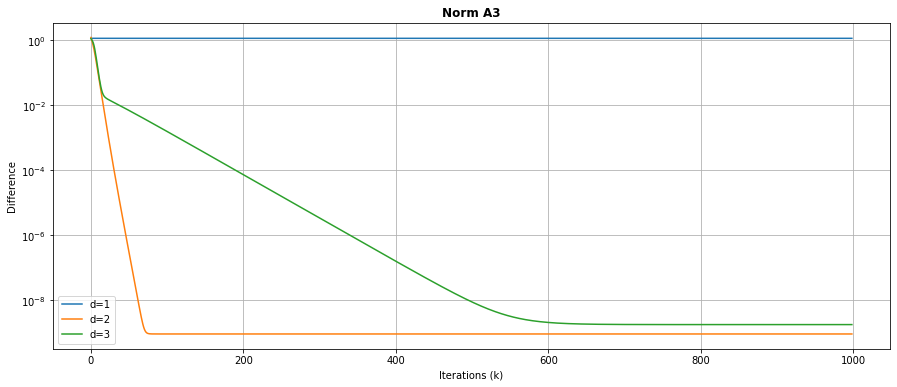

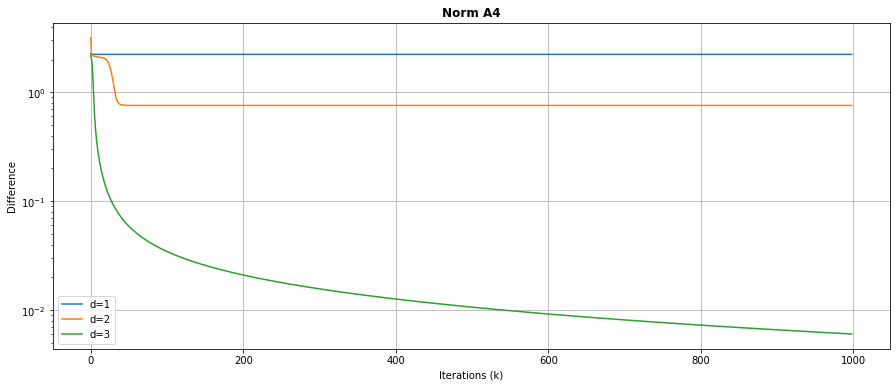

In [94]:
A3NormDArray = plotOfNormDVal(A3,delta,maxiter,0,"A3",3)
A4NormDArray = plotOfNormDVal(A4,delta,maxiter,0,"A4",3)

We see the function decreasing as $k$ grows this shows us that 

$$ \rVert A - W_{k+1}H_{k+1} \rVert_{F} \leq \rVert A - W_{k}H_{k} \rVert_{F}$$

is fulfilled which means that the approximation is getting closer to the real answer.
Secondly, we see that when $d$ is getting closer to $rank(A)$ we get faster convergence and a smaller norm. We think this happens because, when the $Rank(A_3) = 2$, we get a smaller norm-value for $d = 2$ than $3$. We will however do a further investigation on this later. And for $A_4$ the smallest norm-value is for $d = rank(A_4)$.

But what happens if we choose $d > rank(A)$? To explore this, we decided to plot $d = 4$ and $5$ for $A_4$ three times to lessen the randomness factor. 

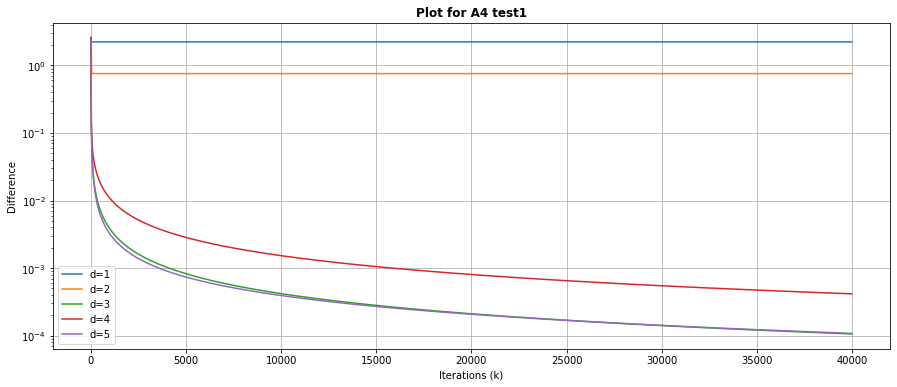

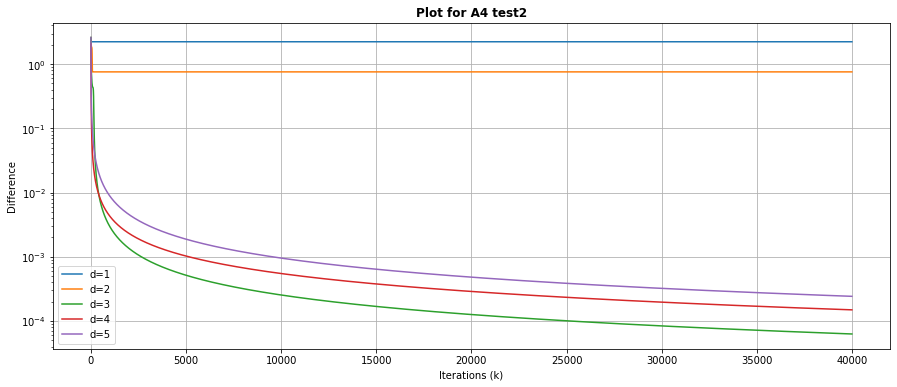

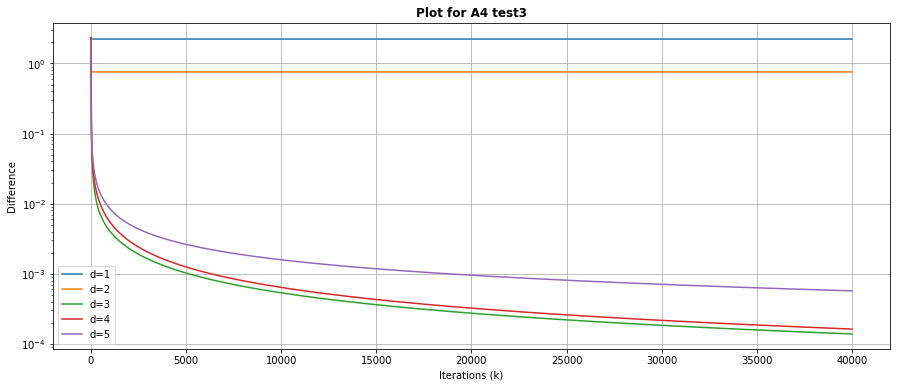

In [66]:
A4NormdArray = plotOfNormDVal(A4,delta,40000,3,"A4 test1",5)
A4NormdArray = plotOfNormDVal(A4,delta,40000,4,"A4 test2",5)
A4NormdArray = plotOfNormDVal(A4,delta,40000,5,"A4 test3",5)


From the plot we see that the accuracy does not increase if $d > rank(A)$, however this does not mean we cannot expect good results from $d > rank(A)$. But it means that we are not guaranteed to have the most accurate result if $d$ goes beyond $rank(A)$. 


### Task 2
We will now investigate the handed-out dataset and apply the NMF to it. We will use 500 images throughout the rest of the rapport. 

We will plot 64 different images from the dataset:

In [46]:
# deloppgave 1
def load_images(N):
    # Allocate array to store images
    faces = np.zeros((24,24,4,N))

    # Iteration variable
    i = 0

    # Iterate over folders
    for subdir, dirs, files in os.walk('./imgs'):

        # Iterate over files
        for file in files:

            # Filepath to load from
            filepath = subdir + os.sep + file

            # Make sure that the file is a .png
            if filepath[-3:] == 'png':

                # Load the image
                im = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)

                # Convert it to RGBA and rescale pixels
                faces[:,:,:,i] = cv2.cvtColor(im, cv2.COLOR_BGRA2RGBA)/255.0

                i+=1
            if i == N:
                break
    return faces

# Number of faces to keep in final array
N = 500

# Load all 10000 images
faces = load_images(10000)

# Select N random images
choices = np.random.choice(faces.shape[-1],N, replace = False)
faces = faces[:,:,:,choices]

In [47]:
# Code for plotting images
def plotimgs(imgs, nplot = 8, rescale = False, filename = None):
    # We will change some of the parameters of matplotlib, so we store the initial ones
    oldparams = plt.rcParams['figure.figsize']

    # New params to make better plot. There definitely exists better ways of doing this
    plt.rcParams['figure.figsize'] = (16, 16)

    # Initialize subplots
    fig, axes = plt.subplots(nplot,nplot)

    # Set background color
    plt.gcf().set_facecolor("lightgray")

    # Iterate over images
    for idx in range(nplot**2):
        
        # Indices
        i = idx//nplot; j = idx%nplot

        # Remove axis
        axes[i,j].axis('off')

        # Rescale RGB channels by dividing my maximal value
        if rescale:
            scaled_img = np.copy(imgs[:,:,:,idx])
            scaled_img[:,:,:3] = scaled_img[:,:,:3]/np.max(scaled_img[:,:,:3])
            axes[i,j].imshow(scaled_img)
        else:
            axes[i,j].imshow(imgs[:,:,:,idx])
    
    # Tight layout so images will appear closer together
    plt.tight_layout()

    # Save if filename is given
    if filename is not None:
        plt.savefig(filename)

    plt.show()

    # Return to old parameters
    plt.rcParams['figure.figsize'] = oldparams

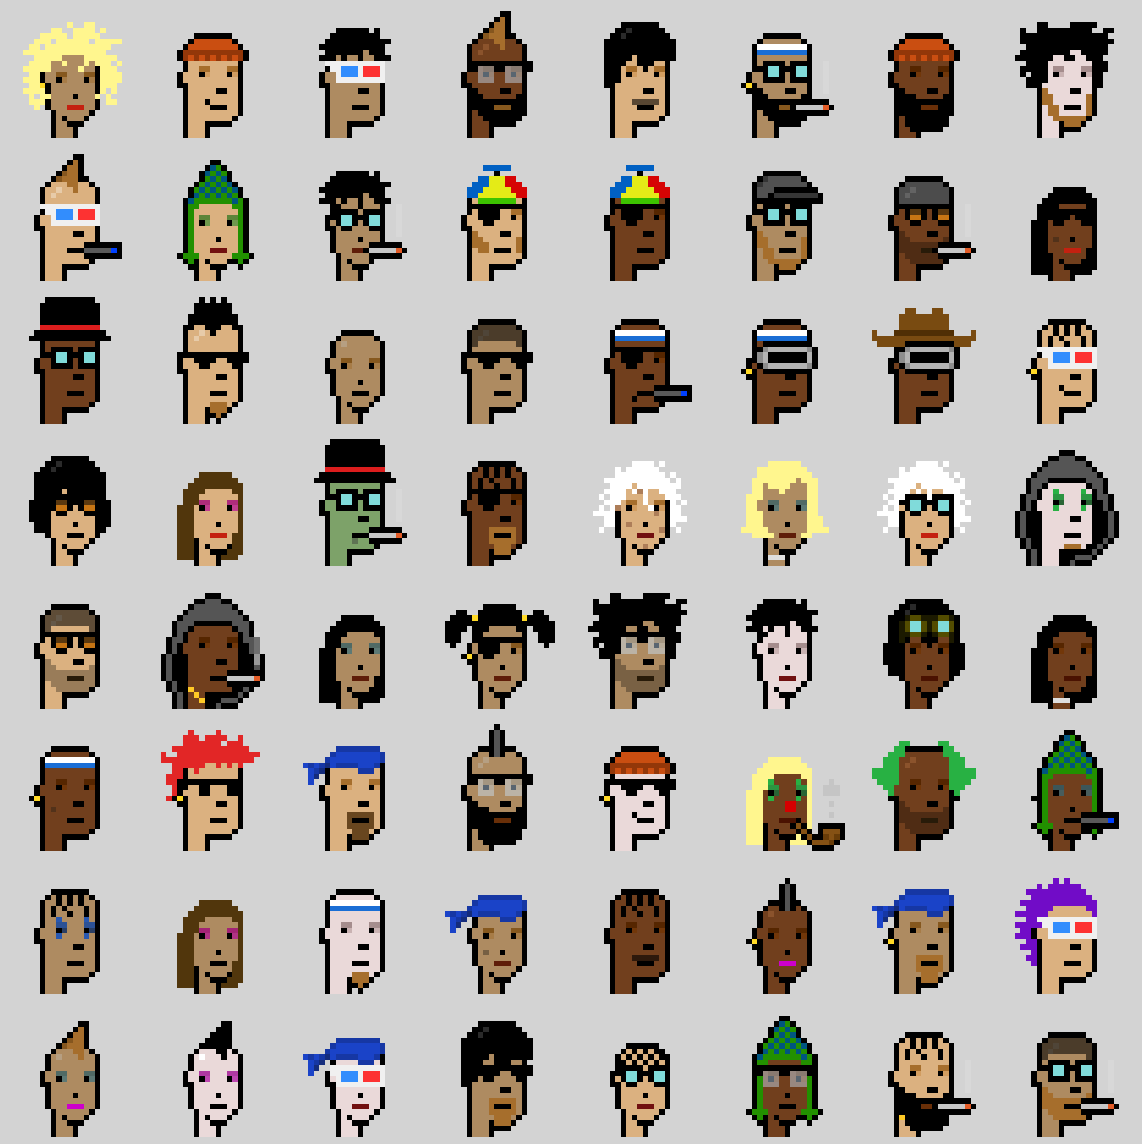

In [48]:
plotimgs(faces, 8)

We will now find the mean of the dataset above. 

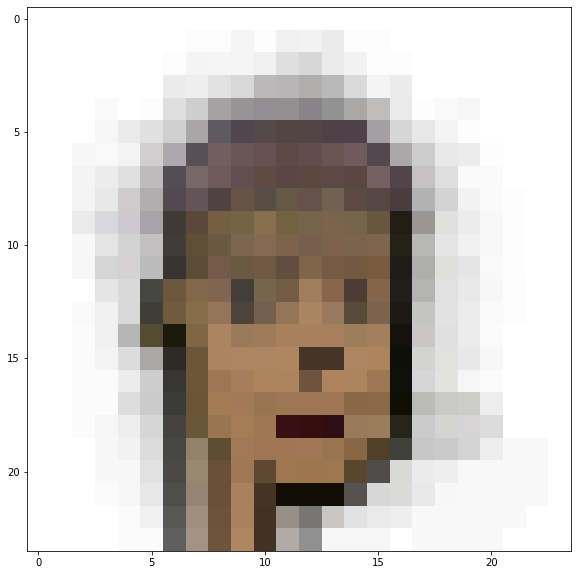

In [68]:
meanFaces = np.mean(faces, -1)
plt.figure(figsize=(15,10))
plt.imshow(meanFaces)
plt.show()


The picture represents the most common features. For instance, we see that the average hair color is brown. Next, we see that the placement of the eyes, mouth and nose is almost the same for every image from the dataset. Lastly, we can see some blurry parts from the picture, for example around the head. This means that most of the images (from the dataset) have features that are around the head, and/or that the shape of the head may vary. 

We want to investigate the opacity of the picture. 


In [50]:
meanFacesOpacity = meanFaces[:,:,3]

Now, we have the opacity-array for the picture. We are interested in finding how many pixels that have no opacity. 

In [51]:
print(len(np.argwhere(meanFacesOpacity == 0)))

166


We get 166 pixels with no opacity. This means that these pixels have no features/color for all images from the dataset. Further on, we can look at values (from the opacity-array) greater than zero. If we multiply this value with three, we get the upper boundary for the rank of the faces-matrix.

In [69]:
print(len(np.argwhere(meanFacesOpacity != 0)))
print(len(np.argwhere(meanFacesOpacity != 0))*3)

410
1230


Here we see that the rank must be lower than $1230$. We want to verify this by finding the rank of the faces-matrix. We are going to use the SVD-method, and from this we get $u$, $s$ and $vh$ matrices. By looking at singular values greater than $10^{-10}$ (because of machine inaccuracy) from the $s$, we get the rank of the faces-matrix.

In [70]:
u, s, vh = np.linalg.svd(faces.reshape(24*24*4,500), full_matrices=False)
print(len(np.argwhere(s > 1e-10)))

379


Here we see that the rank of the faces-matrix is $379$, and this is lower than $1230$. 

Now, we want to apply the NMF to the 3 color channels, using $d = 64$. We will be using our NMF-algorithm from earlier in our report. Here we will investigate what happens when we plot the columns of $W$.

In [52]:
# Split the images into opacity and rgb channels
facesOpacity = faces[:,:,3,:]
facesRGB = faces[:,:,:3,:]

shape = facesRGB.shape

#This is the matrix we will apply the NMF to
facesReshaped = facesRGB.reshape(np.prod(shape)//N, N)

wRGB,hRGB, normRGB = NMF(facesReshaped,64,delta,maxiter,0)

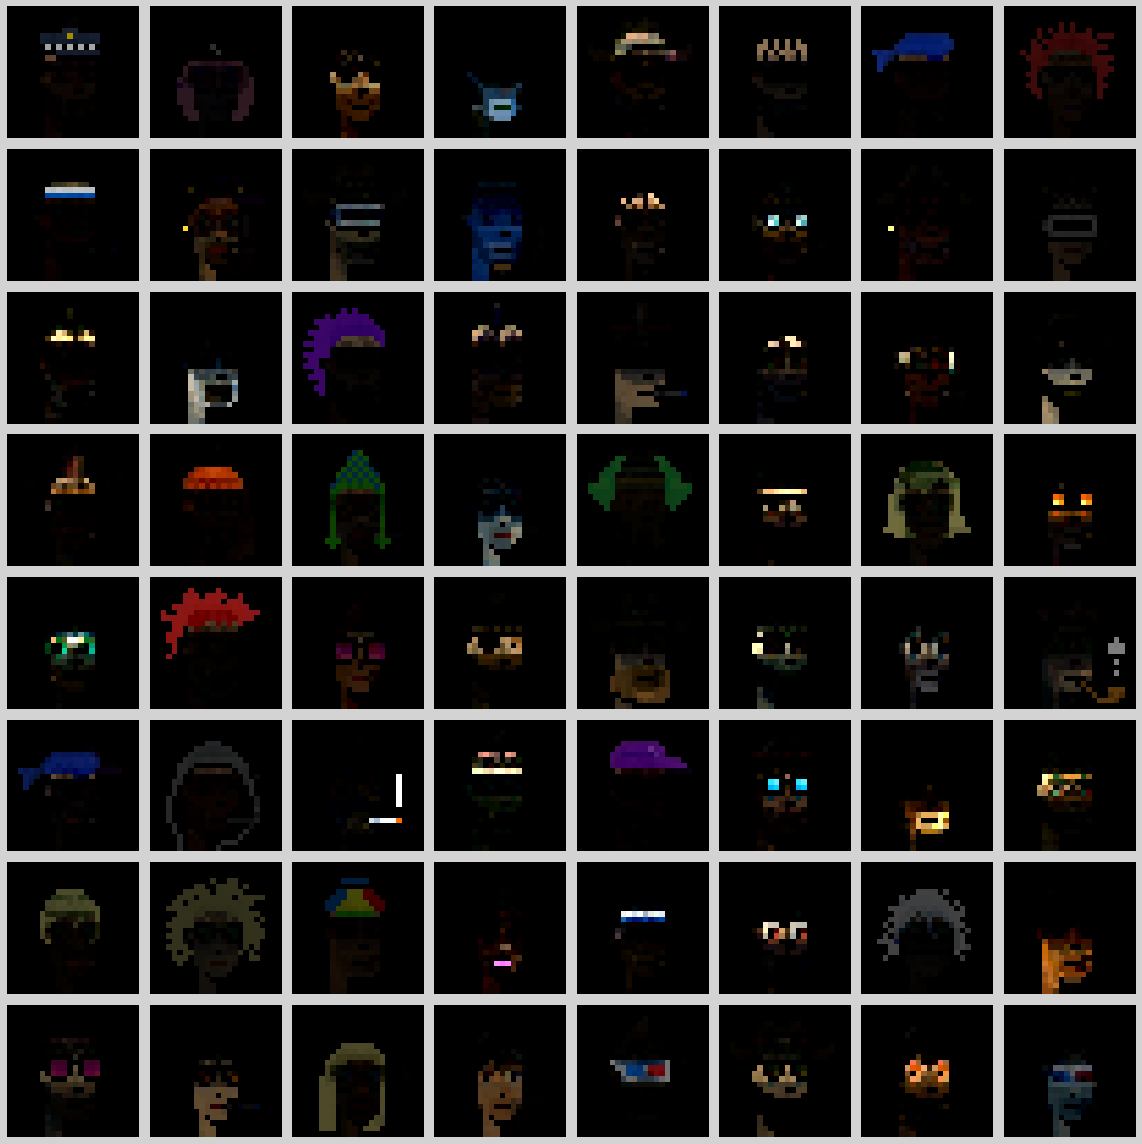

In [53]:
wRGB = wRGB.reshape((24,24,3,64))
wRGB = np.maximum(0.0,np.minimum(1.0, wRGB))  # Clip to lie between 0 and 1 
plotimgs(wRGB,8)

Here we can see 64 different plots of all the columns in $W$. What we observe is different features that can be added together to approximate a character.
  
The columns in $W$ captures the most distinct features in our plot. However, we can see some artifacting in some of the features. By artifacting we mean visible anomalies. 


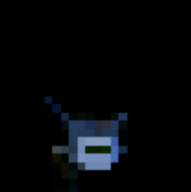
Here is an example of artifacting of the plot. If this was a perfect plot, we would expect the mask to be completely white. However here we notice that the mouth is showing under the mask, so some of the features are overlapping. 



We can try setting $d$ to a higher value to fix this issue. 

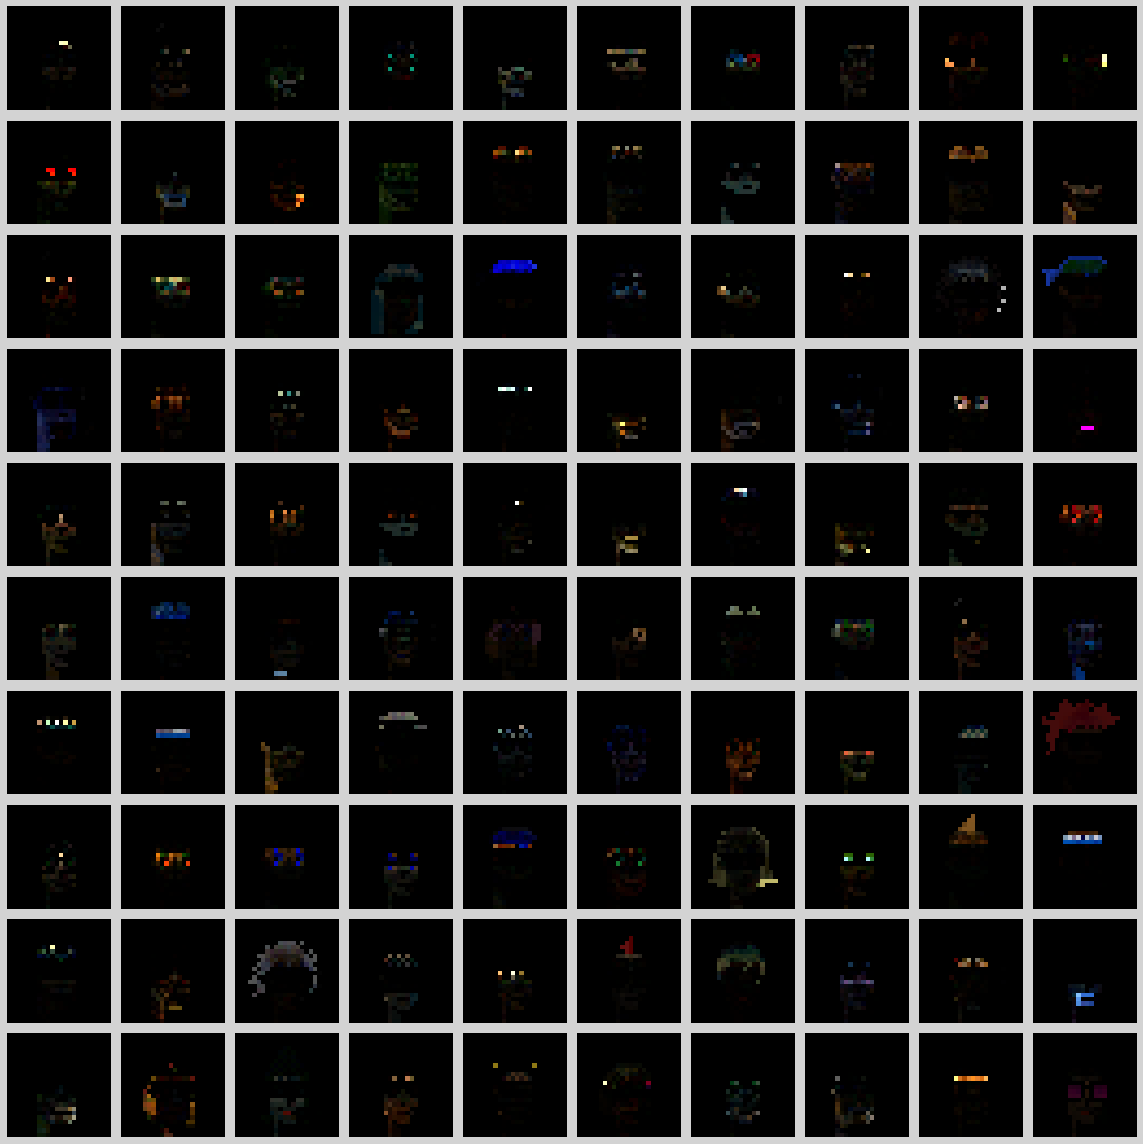

In [21]:
wRGB,hRGB, normRGB = NMF(facesReshaped,300,delta,maxiter,0)
wRGB = wRGB.reshape((24,24,3,300))
wRGB = np.maximum(0.0,np.minimum(1.0, wRGB))
plotimgs(wRGB,10)

Here we set $d=300$. We choose to plot $100$ images to just show that we get more features. In theory we can plot 300 images, but it will be hard to compare the two plots if we have that many images. 



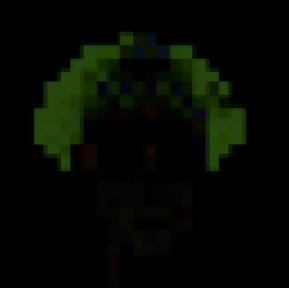|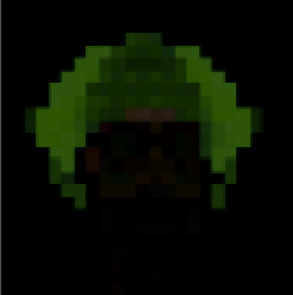
:-----------------------:|:-------------------------:
$$d=300$$                |  $$d=64$$



				

Here we can see that with $d = 300$ we end up splitting our features over too many vectors. Therefore, the image above has fewer green pixels than it is supposed to have, so we can conclude that $d = 300$ is too high for our purpose. 

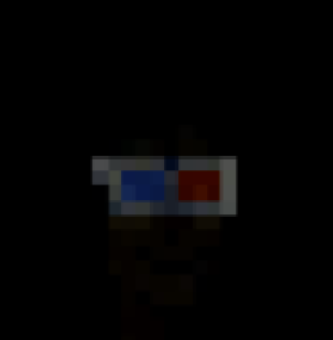|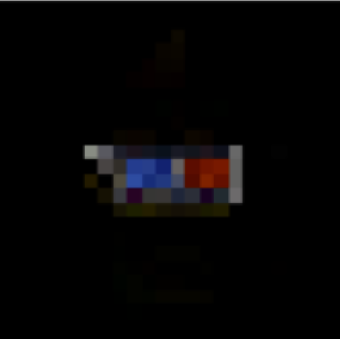
:-----------------------:|:-------------------------:
$$d = 100$$               |  $$d=64$$
 

These two images show the feature 3D-glasses with $d = 100$ and $d = 64$. We can see that for $d = 100$ we get a more distinct pair of glasses. This is because we split up our features into more vectors than for $d = 64$ and so the features don't overlap.


Let us now investigate for a smaller $d$.

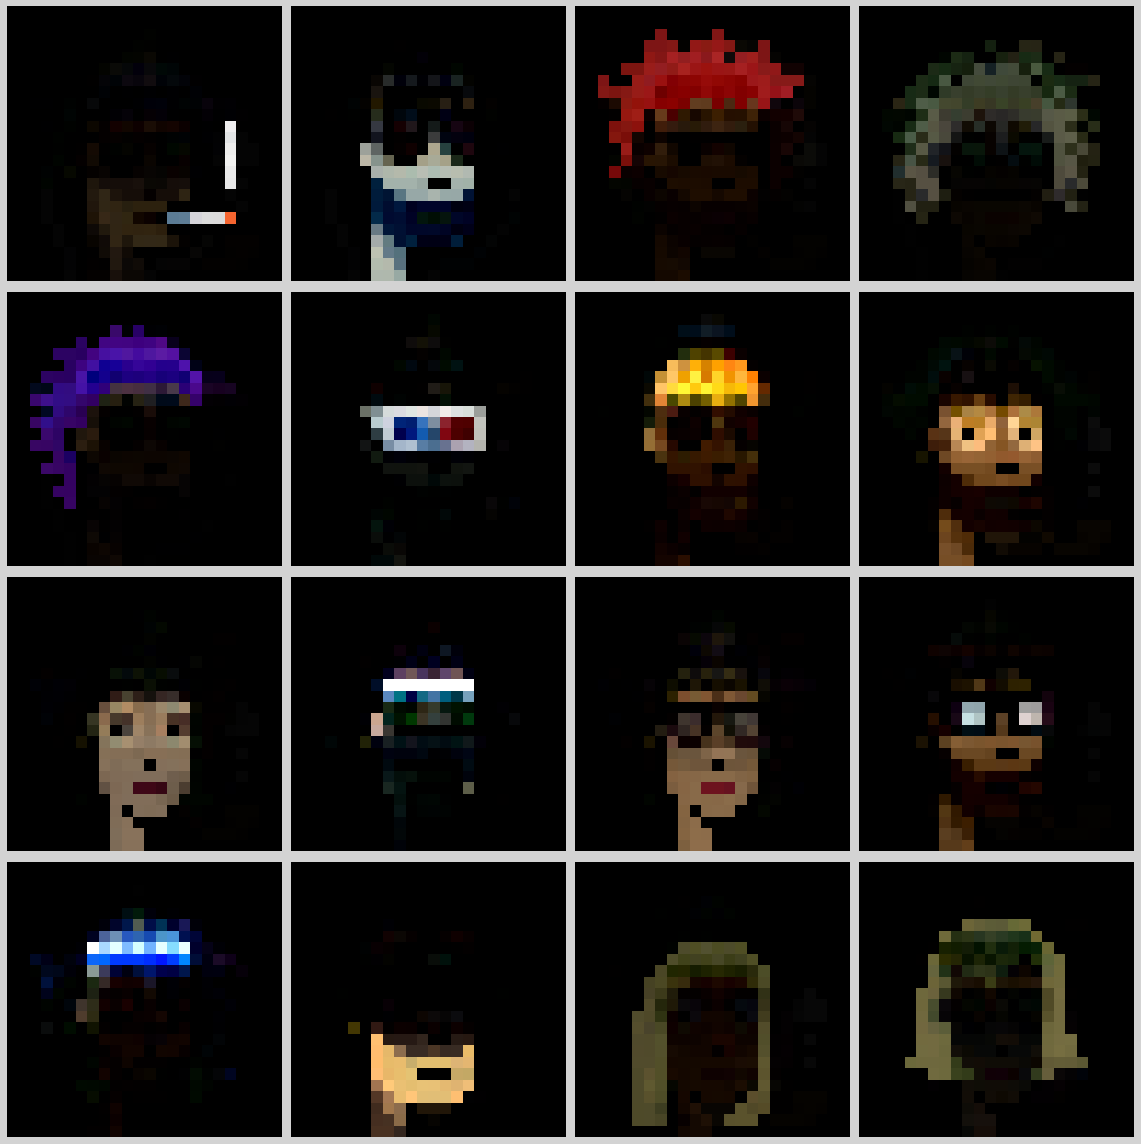

In [22]:
wRGB,hRGB, normRGB = NMF(facesReshaped,16,delta,maxiter,0)
wRGB = wRGB.reshape((24,24,3,16))
wRGB = np.maximum(0.0,np.minimum(1.0, wRGB))
plotimgs(wRGB,4)

Here we set $d=16$. We get 16 images and as expected these images will be a kind of mashup of several features. Which is in accordance with theory.

Now we want to use the NMF to reconstruct the images we already plotted above.

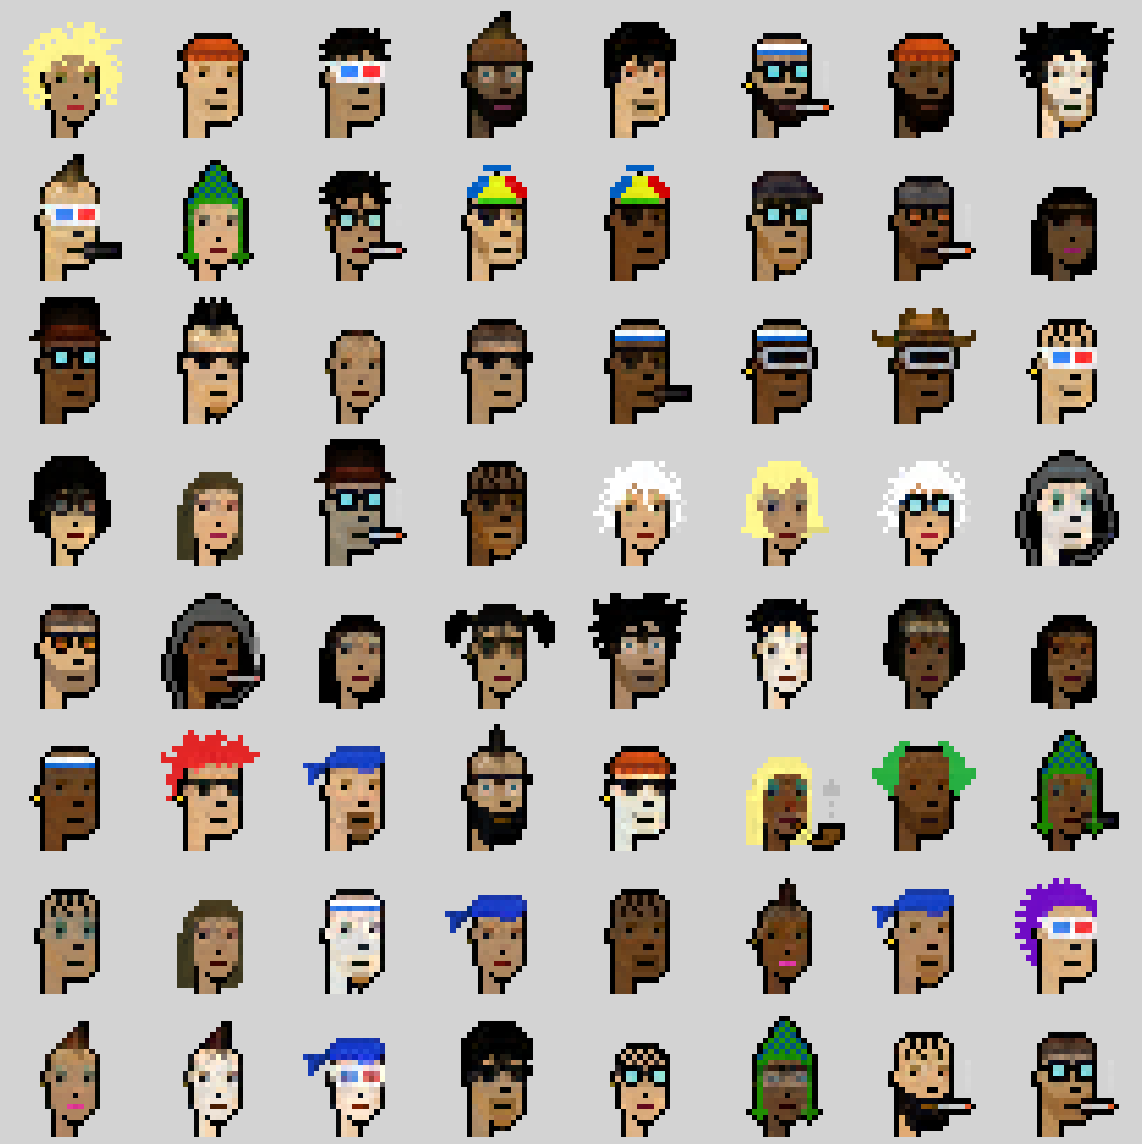

In [71]:
wRGB,hRGB, normRGB = NMF(facesReshaped,64,delta,maxiter,0)
newFace = (wRGB@hRGB)
newFace = newFace.reshape((24,24,3,500))
newFacesWithOpacity = np.zeros(faces.shape)
newFacesWithOpacity[:,:,:3,:] = newFace
newFacesWithOpacity[:,:,3,:] = facesOpacity
newFacesWithOpacity = np.maximum(0.0,np.minimum(1.0, newFacesWithOpacity))
plotimgs(newFacesWithOpacity,imageSize)


We can see that the reconstructions are overall fine. Generally, we can see that the reconstructions are not quite as good as the original. This can be explained by machine rounding errors and the small delta we add when we are doing an iteration.

We can clearly see similarities and the most important features are captured in the reconstruction, however the rarer features are not reconstructed as well as in the original image. Such as the Zombie with the tophat, who was supposed to have green skin. This is because the rarer features are underrepresented in our dataset. Therefore, they will be “washed” out.  



When we plot the norm as a function of $k$ as we did earlier.

In [72]:
def plotOfNormDValNFT(A,delta,maxiter,seed,name):
    dValArray= [16,32,64]
    ANormArray = np.zeros((len(dValArray),maxiter))
    index = 0
    plt.figure(figsize=(15,6)) #figsize
    
    for i in dValArray:
        WNext, HNext,ANormDArray= NMF(A, i, delta, maxiter, seed)
        ANormArray[index] = ANormDArray
        plt.plot(ANormArray[index,1:],label = f"d={i}") #plotting the data
        index += 1
        
    plt.xlabel("Iterations (k)") #xlabel
    plt.ylabel("Difference") #ylabel
    plt.yscale("log") #scale of y axis
    plt.title(f"{name}",fontweight="bold") #title
    plt.grid() #showing a grid
    plt.legend() #placing legend
    plt.show() 
    return ANormArray

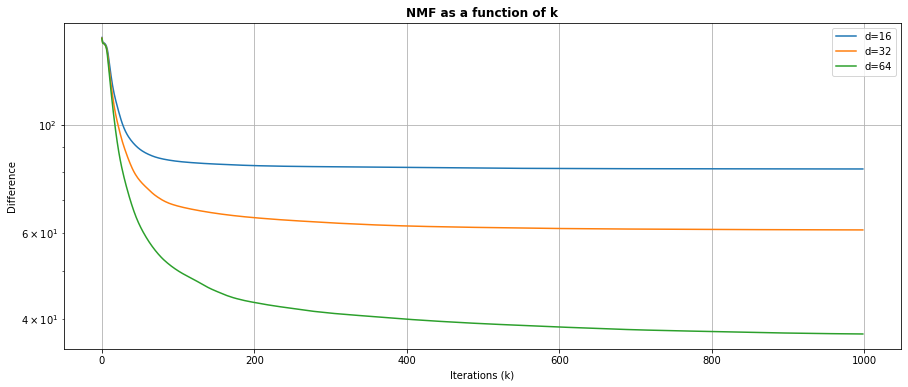

Distance between blue og orange 20.335256275555402
Distance between orange og green 23.64973593532877


In [73]:
ANormArray = plotOfNormDValNFT(facesReshaped,delta,1000,0,"NMF as a function of k")
print("Distance between blue og orange",ANormArray[0,-1]-ANormArray[1,-1])
print("Distance between orange og green",ANormArray[1,-1]-ANormArray[2,-1])

We once again see the result becoming more accurate when $k$ is increased. We also see a convergence as the slope of the function is getting less and less steep. 

If we look at the distance from the slope given by $d = 16$ and $d = 32$ and the distance between the slope of $d = 32$ and $d=64$ we get that they both are about the same size.
Why this is significant, we will look at in more detail later. The gist of it, is that the scale seems to be logarithmic.


We can see from the latest plot that if we want the difference to decrease with the same amount, we need to double $d$ each time. This is because the error decreases  approximately with a logarithmic scale. Let us look at this norm as a function of $d$.

In [87]:
def NormDValNFT(A,delta,maxiter,seed,noisyBool):
    dValArray = [16,64,100,120,140,160,180,220,250]
    ANormArray = np.zeros(len(dValArray))
    index = 0
    
    
    for i in dValArray:
        WNext, HNext,ANorm = NMF(A, i, delta, maxiter, seed)
        if noisyBool == True:
            ANormArray[index] =  np.linalg.norm(facesReshaped - WNext@HNext) #this will be used later
        else:
            ANormArray[index] = ANorm[-1]
            
        index += 1
    
    return dValArray,ANormArray

def plotNormDValNFT(dValArray,ANormArray,name):
    plt.figure(figsize=(15,6)) #figsize
    plt.plot(dValArray,ANormArray) #plotting the data
    plt.xlabel("d") #xlabel
    plt.ylabel("Difference") #ylabel
    plt.yscale("log") #scale of y axis
    plt.title(f"{name}",fontweight="bold") #title
    plt.grid() #showing a grid
    plt.show() 

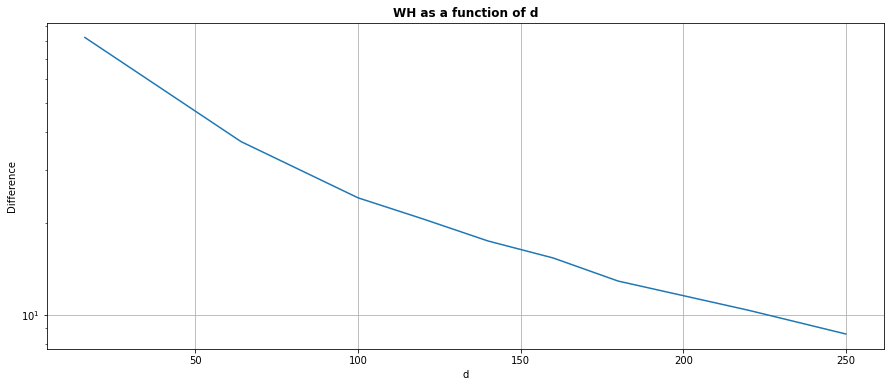

In [89]:
dValArray,ANormArray = NormDValNFT(facesReshaped,delta,1000,0,False)
plotNormDValNFT(dValArray,ANormArray,"WH as a function of d")

Since we have adjusted the scale to be logarithmic, we get approximately a linear function which is what we expect.

### Task 3

This far we have investigated the use of NMF on a “perfect” picture. Now we want to add noise to investigate how this will affect the reconstruction. We will add noise using additive Gaussian noise.

Again, we will plot 64 images, like we did earlier. 

In [28]:
def add_noise(imgs_reshaped, sigma = 0.1):
    """
    Adds gaussian noise to images as described in text.
    Note that imgs must be given as a (24*24*3, N) numpy array, i.e the reshaped images
    Input:
        imgs_reshaped: (1728,N) numpy array
        sigma: scalar, noise level
    Output:
        noisy_faces: (1728,N) numpy array containing noisy images
    """
    # Noise level
    sigma = 0.1

    # Array that will store the rgb channels of the noisy images
    noisy_faces = np.copy(imgs_reshaped)

    # Number of noisy values we need
    nnzero = facesReshaped[np.nonzero(imgs_reshaped)].shape[0]

    # Sample noisy values and add noise
    noise = np.random.normal(0.0,1,nnzero)
    noisy_faces[np.nonzero(imgs_reshaped)] += sigma*noise

    # Clip to lie between 0 and 1 so that we can still interpret them as images
    noisy_faces = np.maximum(0.0,np.minimum(1.0, noisy_faces))

    return noisy_faces

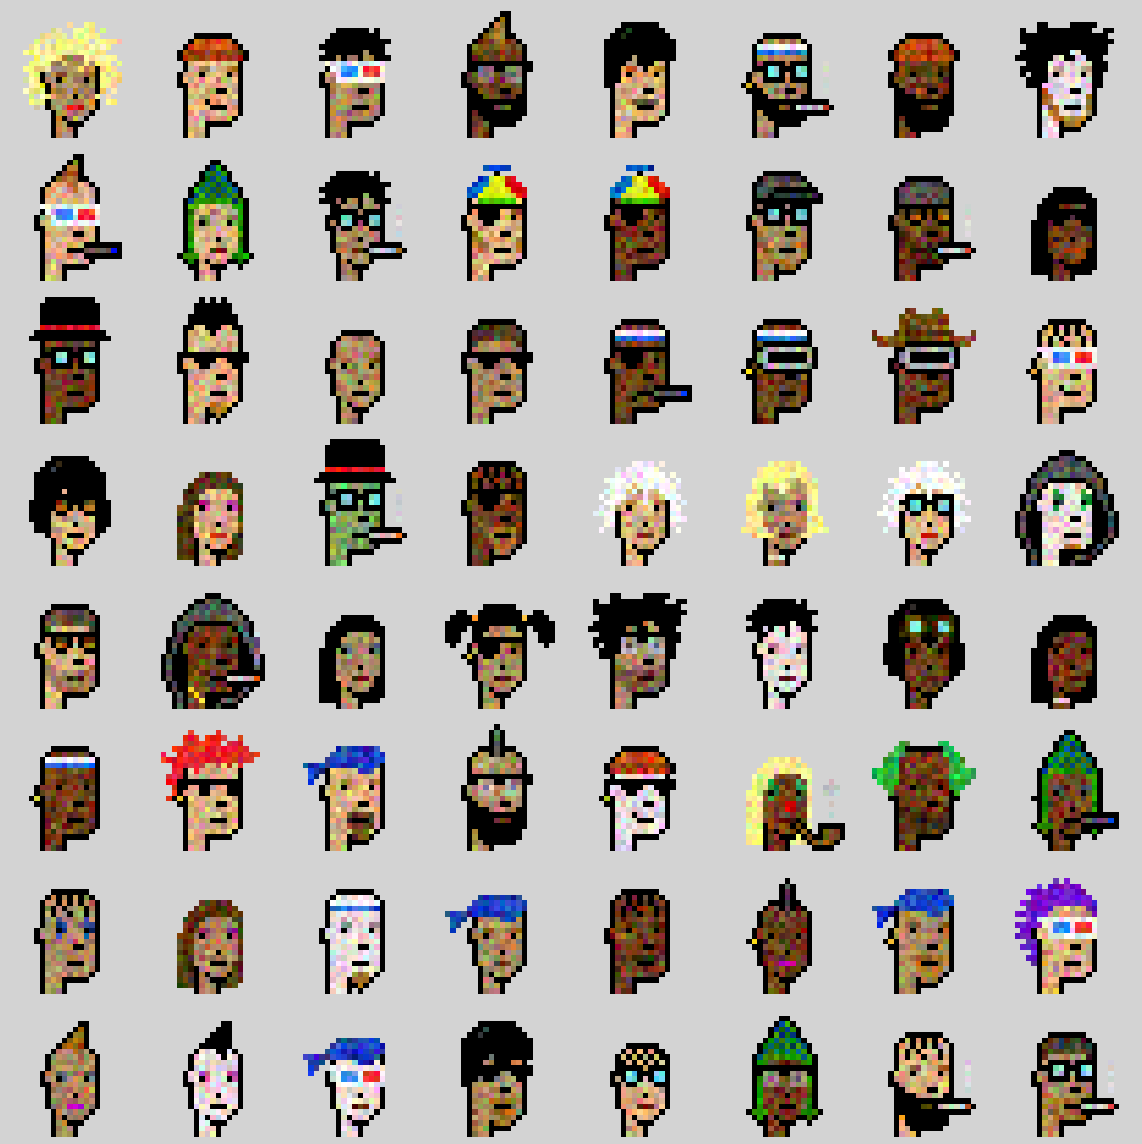

In [29]:
noisyFaces = add_noise(facesReshaped)

# For plotting noisy images we add the opacity
noisyFacesWithOpacity = np.zeros(faces.shape)
noisyFacesWithOpacity[:,:,:3,:] = noisyFaces.reshape(facesRGB.shape)
noisyFacesWithOpacity[:,:,3,:] = facesOpacity
plotimgs(noisyFacesWithOpacity)

In [77]:
# Calculate the error of the noisy images
noiseResidual = np.linalg.norm(noisyFaces - facesReshaped)
print(noiseResidual)

41.81437906969826


Here we also have calculated $|A_{noisy}-A|_F$, where $A_{noisy}$ is the matrix containing noisy images. This residual is the amount of noise in the noisy image. 

Now we will be using the same approach as we did in task 2, to fit an NMF using $d=64$ to the noisy images.

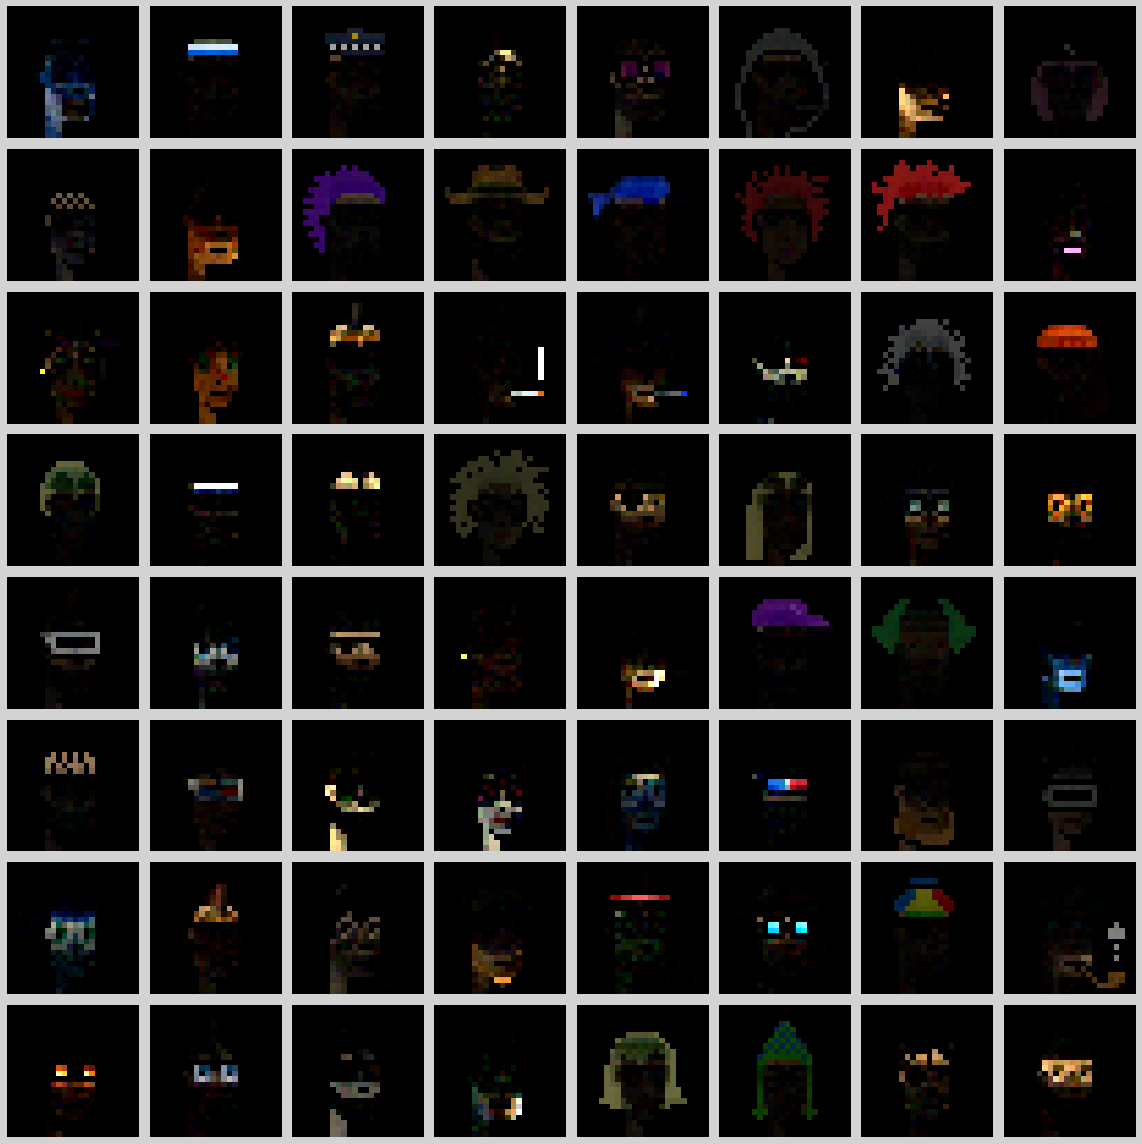

In [30]:
noisyW, noisyH, normNoisy = NMF(noisyFaces, 64, delta, maxiter, 0)
noisyW = noisyW.reshape((24,24,3,64))
noisyW = np.maximum(0.0,np.minimum(1.0, noisyW))
plotimgs(noisyW,8)

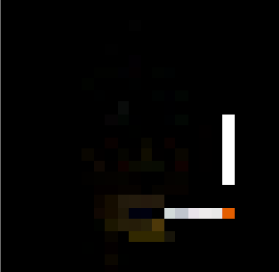|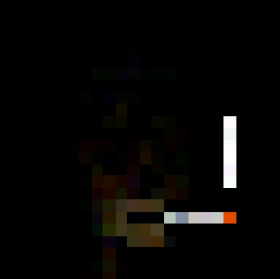
:-----------------------:|:-------------------------:
$$without \enspace noise$$	         |$$with \enspace noise$$


In the case where we have added noise, we can clearly see the main feature, the cigar in this case. But we can also see more of the face than in the column without noise. And this makes sense since we have added more details to the matrix. The image with noise is comparable to the images with a lower $d$ value like we investigated earlier since we have less distinct features in each case. 


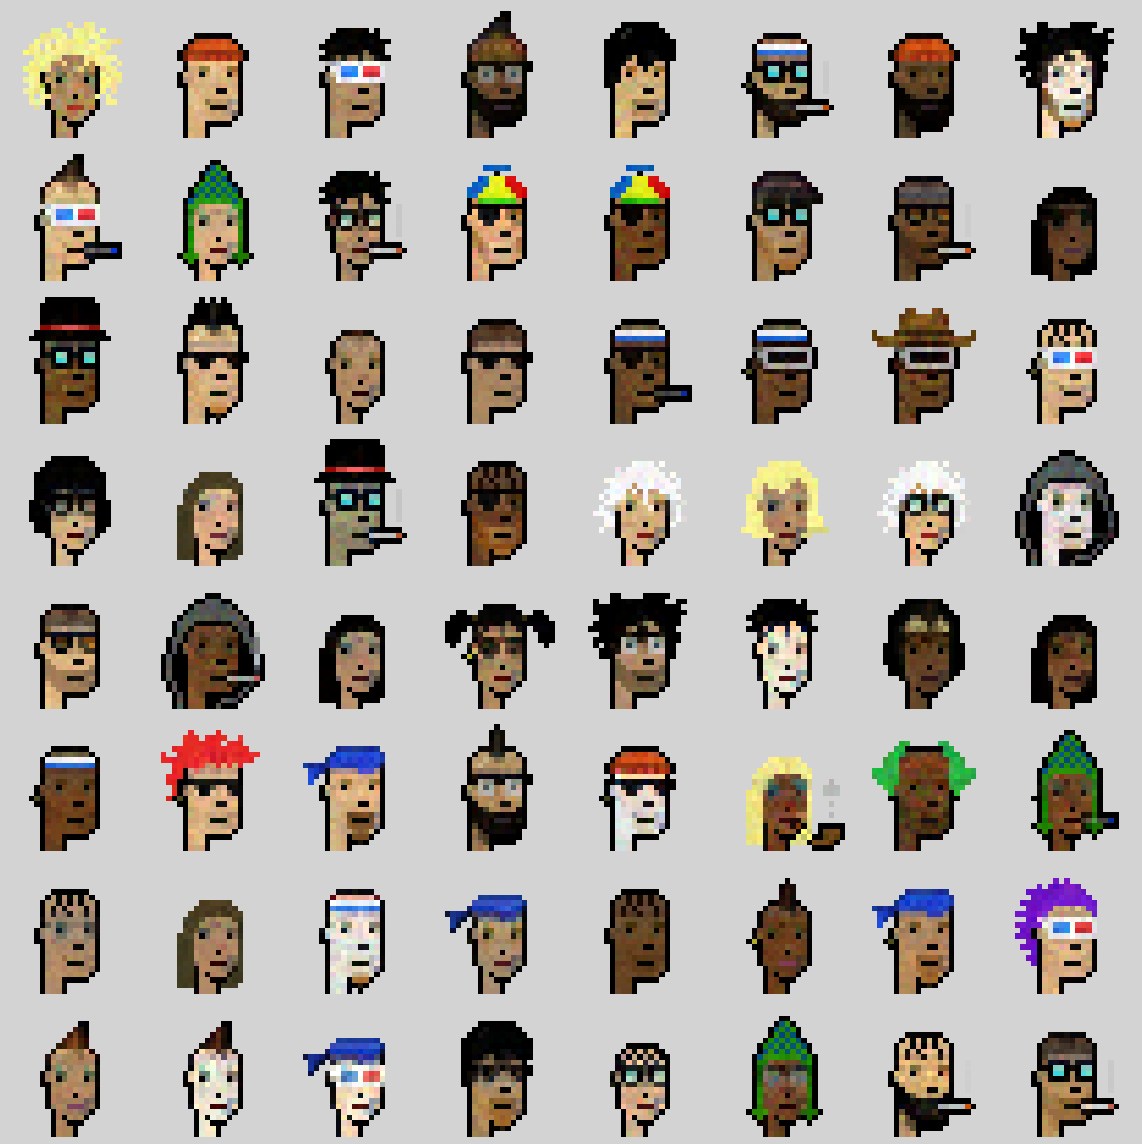

In [31]:
# For plotting noisy images we add the opacity
newFace = (noisyW@noisyH)

newFace = newFace.reshape((24,24,3,500))

noisyFacesWithOpacity = np.zeros(faces.shape)
noisyFacesWithOpacity[:,:,:3,:] = newFace
noisyFacesWithOpacity[:,:,3,:] = facesOpacity
noisyFacesWithOpacity = np.maximum(0.0,np.minimum(1.0, noisyFacesWithOpacity))
plotimgs(noisyFacesWithOpacity,imageSize,filename="punks3.png")


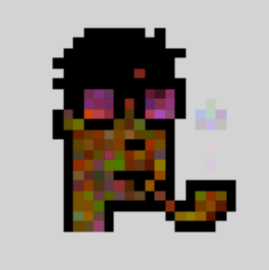|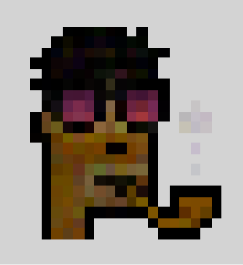
:-----------------------:|:-------------------------:
$$ Original \enspace with \enspace noise $$	         |$$ reconstruction \enspace with \enspace noise$$


When applying NMF, we expect denosing. We can see that the reconstruction has less noise than the original image with noise, we can explain this with the fact that the noise is spread out in a random pattern making it rarer than the common features. Also, since the noise is less representative of the whole image it gets discarded during the NMF-algorithm.



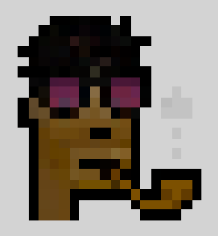|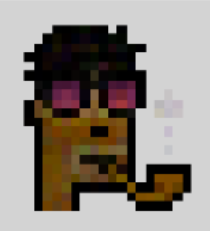|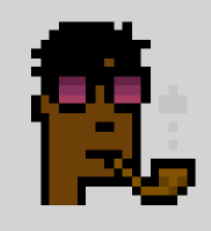
:-----------------------:|:-------------------------:|:-------------------------:
$$ reconstruction \enspace without \enspace noise $$ |$$reconstruction \enspace with \enspace noise$$|$$Original$$

We can observe that the noisy image is a bit noisier, as expected. But we can also observe that the colors in the noisy reconstruction are a bit more vibrant, and more similar to the original image. This might be because the noise is introducing more vibrant colors that can be picked up by the NMF. This is however not an explanation, only a hypothesis. This is an advantage when we want rarer features to show up, for example green skin. 

To quantify the amount of noise we wish to plot the norm as a function of $d$.


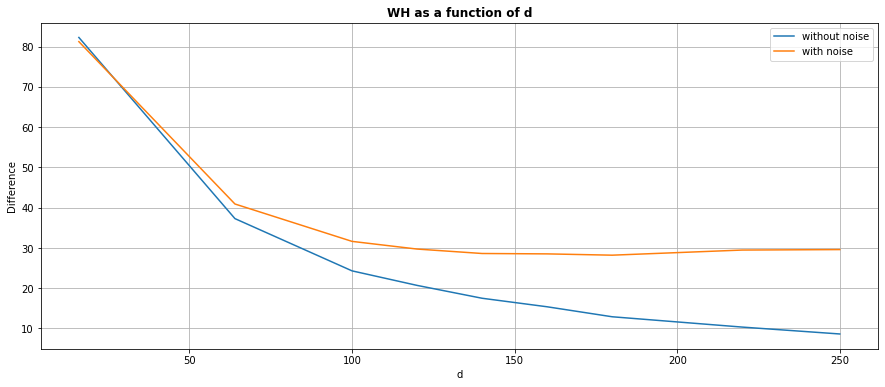

In [90]:
def plotNormNFTWithNoise(dValArray,ANormArrayNoise,name):
    plt.figure(figsize=(15,6)) #figsize
    plt.plot(dValArray,ANormArray,label = f"without noise") #plotting the data
    plt.plot(dValArray,ANormArrayNoise,label = f"with noise") #plotting the data
    plt.xlabel("d") #xlabel
    plt.ylabel("Difference") #ylabel
    plt.title(f"{name}",fontweight="bold") #title
    plt.grid() #showing a grid
    plt.legend() #placing legend
    plt.show() 

ANoise = noisyFaces
dValArray,ANormArrayWithNoise = NormDValNFT(ANoise,delta,maxiter,0,True)
plotNormNFTWithNoise(dValArray,ANormArrayWithNoise,"WH as a function of d")

For the lower values of $d$ we can see that the norm is big, meaning there is a big difference between the original image and the noisy reconstruction. We are essentially underfitting our data, meaning we have too few basis vectors. This will lead to the features being misrepresented. 

On the other side we have overfitting; this occurs when we have bigger $d$ values. The problem with overfitting is that the noise will be interpreted as a feature and therefore be a part of the reconstructions.

In [78]:
minDval = np.where(ANormArrayWithNoise == np.min(ANormArrayWithNoise))
print(dValArray[minDval[0][0]])

160




Between underfitting and overfitting we find a minimum that gives us the $d$ value with the smallest norm. The best "fit" is when $d = 160$.


## Conclusion  


In this project we have studied different aspects of non-negative matrix factorization. First, we found out that the NMF gives better result for a greater $d$ and is unique when $d = rank(A)$ for this algorithm. However, this is not satisfied for $d$ greater than the rank of the orginal matrix $A$. Secondly, we saw that the norm decreases for greater $k$ values, but this trend tappers off. 

We have seen that NMF works well for simple matrices, but we want to see if it is applicable on images. After prosessing the images with NMF we get a new matrix $W$. The columns of $W$ represent features of the CryptoPunks. We can find the most common features by looking at the mean-matrix. For example, brown is the average hair color. Just like with the simple matrices we got a reconstruction that was overall good and better with greater $d$. We found an upper bound for the rank of the original image (faces).

Lastly, we introduced noise to our dataset and studied the effects of this. The columns of $W$ were less distinct as if we had chosen a low $d$ value. As expected, the noisy reconstructions were worse than the noiseless reconstructions. The noisy reconstructions, however, were less noisy than the original noisy images. This is because NMF has a denoising property. When choosing a $d$ value, one must be mindful of over- and underfitting. We found out that underfitting occurred before $d = 160$ and overfitting after $d = 160$.

An advantage of applying NMF for images, is that the storage space required will be less than for the original image. Another important advantage is that we have access to $W$. The columns of this matrix contains CryptoPunks features which is also the basis vector for our original matrix. When looking at noisy images this method is especially applicable because the reconstruction gets denoised. On the other hand we have disadvantages, such as loss of quality. By this we mean that the reconstruction will never look exactly the same as the original. A disadvantage of applying NMF to noisy images is that you no longer can choose $d = rank(A)$ and expect the "best fit". You have to find the best fit by for example plotting the norm for different values of $d$. We found that $d = 160$ gives the "best fit". 